### Import of Libaries and definition of some functions

In [3]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from egg import core
from os.path import normpath
import os
from torch.nn import Module
from torch.optim import Adam
from torch import save
from egg.core import Interaction
import matplotlib.pyplot as plt
from rlg.architectures import *
from rlg.loss import *
import rlg
import tqdm
import numpy as np
from PIL.Image import open as im_open
import itertools 
%matplotlib inline

In [4]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

def get_n_gram(n,messages):
    "Compute the n-gram model of given n and given sentences"
    n_gram = {}
    for i in range(len(messages)):
        for x in range(len(messages[i])-n+1):
            if messages[i][x:x+n] in n_gram.keys():
                n_gram[messages[i][x:x+n]] += 1
            else:
                n_gram[messages[i][x:x +n]] = 1

    sorted_n_gram = {k: v for k, v in sorted(n_gram.items(), key=lambda item: item[1],reverse=True)}
    return sorted_n_gram


# Comparison of the loss and log-probs of REINFORCE and Gumbel-softmax

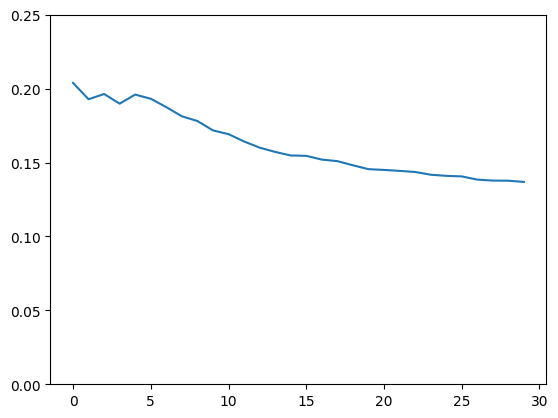

In [5]:
loss_reinf = open("./log_test_loss_RE_25_Epochs.txt", "r")
loss_reinf = loss_reinf.read()
loss_reinf = loss_reinf.replace('\n', ' ').split(" ")
loss_reinf_numbers = []
for loss in loss_reinf:
    try:
        loss_reinf_numbers.append(float(loss))
    except:
        pass
    #loss_reinf.reverse()
#for loss in loss_reinf:
    
epochs = np.arange(0, len(loss_reinf_numbers), 1, dtype=int)

fig, ax = plt.subplots(1,1)
ax.plot(epochs,loss_reinf_numbers)
ax.set_ylim(0, 0.25)
#plt.gca().invert_yaxis()

#yticks(np.arange(0, 1, step=0.01)) 
#ax.yaxis.set_ticks(np.arange(0, 0.4, 0.1))
#ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

#ax.yaxis.set_major_locator(ticker.MultipleLocator(0.01))
plt.show()


#plt.plot(epochs, loss_reinf)
#plt.gca().invert_yaxis()
#plt.(epochs, loss_reinf)
#plt.show()
# printing the data
#print(data_into_list)

# Visual results of the Game

# Loading of the trained game and the data used for evaluation

Set up of the agents and the game

In [6]:
vision = rlg.Vision()
class_prediction = rlg.PretrainVision(vision)
class_prediction.load_state_dict(torch.load('./models/class_prediction.pth', map_location=torch.device('cpu')))

# Agent's and game's setup
sender = rlg.SenderCifar10(class_prediction.vision_module)
receiver = rlg.ReceiverCifar10()
game = rlg.LanguageGame(sender, receiver, sender_entropy_coeff=0.005, receiver_entropy_coeff=0.000)
game.load_state_dict(torch.load('./models/game_REINF_4_5_120Epochs.pth'))

<All keys matched successfully>

Loading of the test data, i.e. 10000 pictures of squares, 10000 pictures of circles and 10000 pictures of triangles

In [7]:
test_shapes = {}
for shape in ["square", "circle", "triangle"]:
    custom_test_data = {}
    test_files = os.listdir("./data/eval/" + shape +"/")
    for i in range(len(test_files)):
        file = test_files[i]
        im = np.moveaxis(
            np.array(im_open("./data/eval/"+ shape + "/" + file)), 2,0) / 255.
        y = [float(value) for value in file[:-4].split(sep=', ')]
        custom_test_data[i] = (torch.tensor(im).to(dtype=torch.float32), torch.tensor(y))
    loader = torch.utils.data.DataLoader(custom_test_data, batch_size=len(test_files), shuffle=True)
    test_shapes[shape] = loader

# N-Gram Analysis

In the following, we will compute the 1-, 2- and 3-Gram Language Models of 10000 example sentences (=messages), which all encode the same geometric shape. We will compute three models, one for squares, one for triangles and one for circles and compare the n-gram models. We hope to identify the symbol or sequence of symbols that encodes the respective shape. 

In [8]:
# extract the messages from the game's interaction object, convert them to strings and format them
messages_shapes = {}
for shape in test_shapes.keys():
    interaction = core.dump_interactions(game, test_shapes[shape], gs=False, variable_length=True)
    messages = []
    for message in interaction.message:
        string = np.array2string(message.numpy(), separator='')[1:-1]
        for symbol in range(len(string)):
            if string[symbol] == "0":
                string = string[:symbol+1]
                break
                
        messages.append(string)
    messages_shapes[shape] = messages

In [9]:
# compute the n_grams
one_grams = {}
two_grams = {}
three_grams = {}
four_grams = {}
five_grams = {}

for shape in messages_shapes.keys():
    one_grams[shape] = get_n_gram(1,messages_shapes[shape])
    two_grams[shape] = get_n_gram(2,messages_shapes[shape])
    three_grams[shape] = get_n_gram(3,messages_shapes[shape])
    four_grams[shape] = get_n_gram(4,messages_shapes[shape])
    five_grams[shape] = get_n_gram(5,messages_shapes[shape])

    

n_grams = [one_grams,two_grams,three_grams,four_grams,five_grams] 

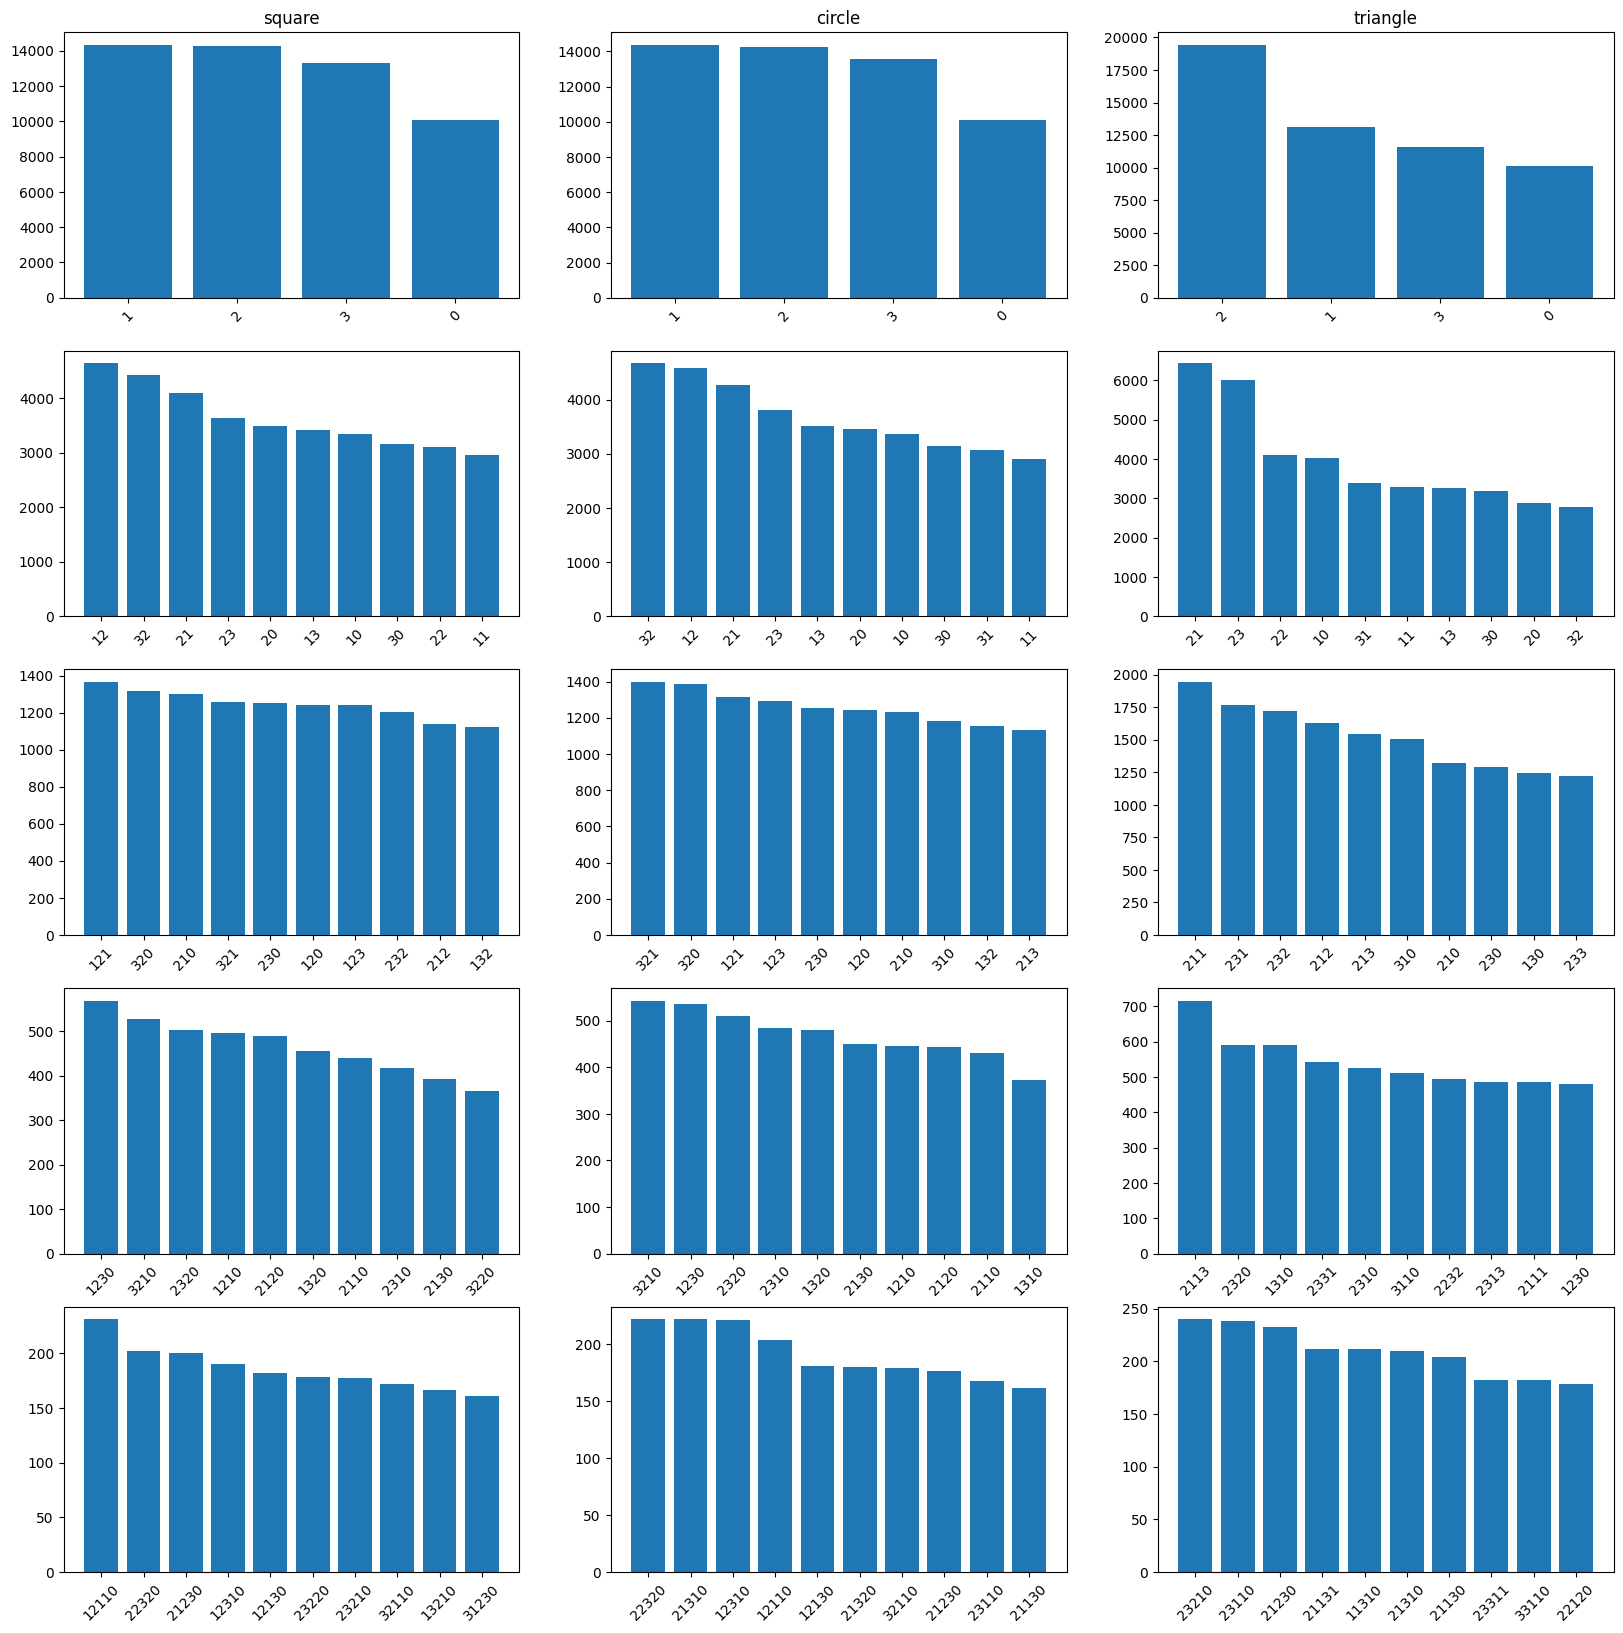

In [10]:
# print the n-grams
plot_data = []
xtick_data = []
for shape in messages_shapes.keys():
    plot_data.append(dict(itertools.islice(one_grams[shape].items(), 10)))
    plot_data.append(dict(itertools.islice(two_grams[shape].items(), 10)))
    plot_data.append(dict(itertools.islice(three_grams[shape].items(), 10)))
    plot_data.append(dict(itertools.islice(four_grams[shape].items(), 10)))
    plot_data.append(dict(itertools.islice(five_grams[shape].items(), 10)))

plot_data = (
    plot_data[0],
    plot_data[5],
    plot_data[10],
    plot_data[1],
    plot_data[6],
    plot_data[11],
    plot_data[2],
    plot_data[7],
    plot_data[12],
    plot_data[3],
    plot_data[8],
    plot_data[13],
    plot_data[4],
    plot_data[9],
    plot_data[14])

fig = plt.figure(figsize=(20,20))
#fig.tight_layout()
columns = 3
rows = 5

for i in range(1, columns * rows +1):
    fig.add_subplot(rows, columns, i)
    if i == 1:
        plt.gca().set_title("square")
    elif i == 2:
        plt.gca().set_title("circle")
    elif i == 3:
        plt.gca().set_title("triangle")
    plt.bar(range(len(plot_data[i-1])), list(plot_data[i-1].values()), align='center')
    plt.xticks(range(len(plot_data[i-1])),list(plot_data[i-1].keys()),rotation = 45)


# Decaying message
Here we investigate how the messages encode the picture. For this purpose, we censecutively delete the last symbol of the message (setting it to the end of sequence symbol 0) and plot the receivers output to the message.

In [11]:
squares=torch.tensor([[1, 2, 3, 3, 0, 0],
        [1, 1, 2, 3, 3, 0],
        [3, 2, 1, 2, 3, 0],
        [2, 1, 3, 1, 2, 0],
        [3, 1, 3, 1, 2, 0],
        [1, 1, 2, 3, 3, 0],
        [3, 3, 0, 0, 0, 0],
        [1, 2, 1, 0, 0, 0]])
circles = torch.tensor([[1, 3, 1, 3, 0, 0],
        [1, 2, 1, 2, 0, 0],
        [1, 3, 2, 0, 0, 0],
        [3, 2, 3, 3, 1, 0],
        [1, 2, 1, 2, 1, 0],
        [3, 3, 2, 2, 2, 0],
        [1, 2, 3, 2, 2, 0],
        [1, 3, 2, 1, 3, 0]])
triangle = torch.tensor([[2, 2, 2, 3, 2, 0],
        [2, 1, 2, 1, 2, 0],
        [2, 2, 1, 2, 3, 0],
        [2, 2, 1, 0, 0, 0],
        [2, 1, 2, 1, 0, 0],
        [2, 3, 3, 1, 1, 0],
        [2, 1, 1, 3, 0, 0],
        [2, 2, 2, 3, 2, 0]])
for i in squares:
    out = game.receiver(i)
    plt.imshow(out.view(3, 100, 100).permute(1, 2, 0).detach().numpy())
    plt.show()
    
for i in circles:
    out = game.receiver(i)
    plt.imshow(out.view(3, 100, 100).permute(1, 2, 0).detach().numpy())
    plt.show()
    
for i in triangle:
    out = game.receiver(i)
    plt.imshow(out.view(3, 100, 100).permute(1, 2, 0).detach().numpy())
    plt.show()
    
"""

messages_decaying = []
for message in custom_messages:
    for index in range(len(message)):
        messages_decaying.append(message[:-index+1].add(np.zeros(index-1)))

generated_images = []
for message in messages_decaying:
    receiver_output = game.receiver(torch.tensor([message]))
    generated_images.append(receiver_output[0].view(3, 100, 100).permute(1, 2, 0).detach().numpy())

fig = plt.figure(figsize=(100,100))
fig.tight_layout()
columns = 3
rows = 6

for i in range(1, columns*rows +1):
    img = generated_images[i-1]
    title = messages_decaying[i-1]
    fig.add_subplot(rows, columns, i)
    fig.tight_layout()
    plt.gca().set_title(title)
    plt.imshow(img)
for i in fig.axes:
    i.set_xticks([])
    i.set_yticks([])

plt.show()
"""

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)